## The Quantum Alternating Operator Ansatz (QAOA) for the MaxCut problem

The Quantum Alternating Operator Ansatz (QAOA) is a quantum algorithm designed for solving combinatorial optimization problems. We start by describing the MaxCut problem, and then show how to use QAOA to solve it.

In [143]:
import numpy as np 
from qflow.templates.circuits import QAOACircuit
from qflow.templates.examples.maxcut_circuit import maxcut_qaoa_example
import pennylane as qml

from tqdm import tqdm
from dataclasses import dataclass
from qflow.utils.maxcut_utils import get_maxcut_graph
from pennylane import AdamOptimizer
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from qflow.utils.utils import get_approximation_ratio
import algorithmx
from qflow.utils.utils import get_all_spinstrings
from qflow.utils.maxcut_utils import get_maxcut_costs, visualize_maxcut_graph
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### The MaxCut problem

The MaxCut problem is a combinatorial optimization problem that asks us to find a cut of a graph that maximizes the number of edges that are "cut" by the cut. A cut of a graph is a partition of the nodes of the graph into two sets. The MaxCut problem is defined as follows:

Given a graph $G = (V, E)$, find a cut $S$ of the graph that maximizes the number of edges that are cut by the cut, i.e., the number of edges $(i, j)$ such that $i \in S$ and $j \notin S$.

Let us generate a random graph to illustrate the MaxCut problem. We will use the `networkx` package to generate a random graph. We will then use the `algorithmx` package to visualize the graph including the optimal solution.

In [164]:
num_nodes = 6
seed =0

graph = get_maxcut_graph(num_nodes, seed=seed)
H, _ = qml.qaoa.maxcut(graph)
num_qubits = len(H.wires)

In [165]:

costs= get_maxcut_costs(graph)
index_min = np.where(costs == costs.min())
min_energy = np.min(costs)
all_bitstrings = get_all_spinstrings(num_qubits)
best_bitstrings = all_bitstrings[index_min, :]

print(
    " index max: {} \n max cut: {} \n solution bitstring: \n {} \n".format(
        index_min, min_energy, best_bitstrings
    )
)
best_bitstring = best_bitstrings[0, 0, :]
visualize_maxcut_graph(graph, best_bitstring)


 index max: (array([11, 52]),) 
 max cut: -9.0 
 solution bitstring: 
 [[[ 1  1 -1  1 -1 -1]
  [-1 -1  1 -1  1  1]]] 



JupyterWidget(events=['{"attrs": {"nodes": {"0": {}, "1": {}, "2": {}, "3": {}, "4": {}, "5": {}}}}', '{"attrs…

## Vanilla QAOA

Let us now implement the Quantum approximate optimization algorithm introduced by [Farhi et al.](https://arxiv.org/abs/1411.4028). We initialize the circuit in the plus state $\left|+\right\rangle = \frac{1}{\sqrt{2}}\left(\left|0\right\rangle + \left|1\right\rangle\right)$, and apply the following circuit:

$$
\begin{align}
    \ket{\boldsymbol{\gamma, \beta}} = U( \beta_p) U(\gamma_p) \dots U(\beta_1) U( \gamma_1) \ket{+}^{\otimes n}.
\end{align}
$$
where $U(\gamma)$ is the unitary operator defined by
$$
\begin{align}
    U(\gamma) = e^{-i \gamma H_C},
\end{align}
$$
and $U(\beta)$ is the unitary operator defined by
$$
\begin{align}
    U(\beta) = e^{-i \beta H_M},
\end{align}
$$
where $H_M$ and $H_C$ are the mixing and the cost Hamiltonians, respectively. The mixing Hamiltonian is defined as
$$
\begin{align}
    H_M = \sum_{i=1}^n \sigma_x^i,
\end{align}
$$
and the cost Hamiltonian is defined as
$$
\begin{equation}
    H_C = \sum_{(i,j)\in E} \frac{1}{2}(1 - \sigma_z^i \sigma_z^j),
\end{equation}
$$
where $E$ is the set of edges in the graph, and $\sigma_z^i$ is the Pauli-Z operator applied to the $i$-th qubit.



In [166]:
from qflow.templates.circuits import QAOACircuit
from qflow.templates.state_preparation import Plus
from qflow.qaoa.mixer_h import x_mixer

circuit = QAOACircuit(H, initial_state=Plus(num_qubits), mixer_h=x_mixer(num_qubits), num_layers=6)
params = circuit.init()

In [147]:
# print(qml.draw(circuit)(params))

In [148]:
stepsize= 0.05
steps = 200
seed = 0

In [149]:
dev = qml.device("default.qubit", wires=circuit.wires)


@qml.qnode(dev)
def loss_fn(params):
    circuit(params)
    return qml.expval(H)


In [150]:
@dataclass
class Datapoint:
    step: int
    exp_val: float
    optimizer: str

In [151]:
optimizer = AdamOptimizer(stepsize=stepsize)

In [152]:
dataset = []
optimizer_id = optimizer.__class__.__name__
print(optimizer_id)
params = circuit.init(seed)

for k in tqdm(range(0, steps + 1)):
    params, exp_val = optimizer.step_and_cost(loss_fn, params)
    dataset.append(Datapoint(k, np.real(exp_val), optimizer_id))

del optimizer

AdamOptimizer


100%|██████████| 201/201 [00:14<00:00, 14.19it/s]


In [153]:

df = pd.DataFrame(columns=["step", "exp_val", "optimizer"])
df = pd.DataFrame([x.__dict__ for x in dataset])
df["exp_val"] = df["exp_val"].astype(float) 

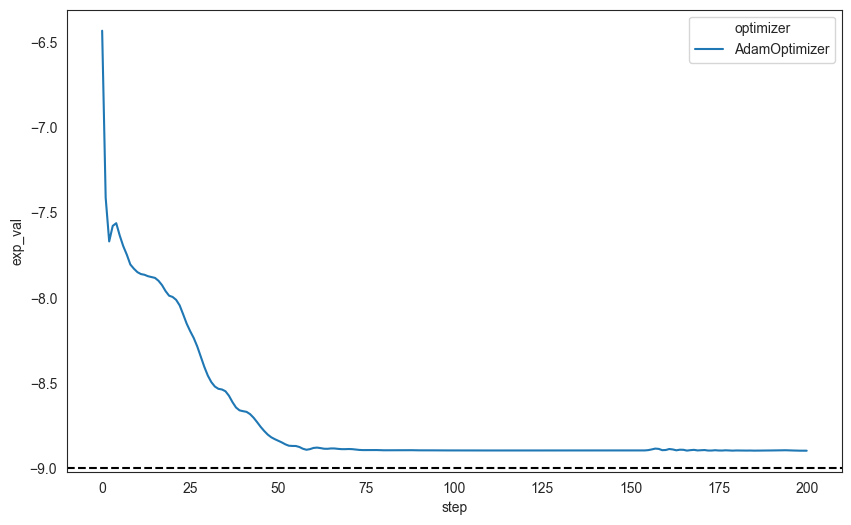

In [154]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style("white")

g = sns.lineplot(
    x="step",
    y="exp_val",
    hue="optimizer",
    data=df,
    ax=ax,
)

ax.axhline(y=min_energy, color="black", linestyle="--", label="Ground state")

## XY-mixer QAOA 

Next, let us have a look at the [XY-mixer QAOA](https://arxiv.org/abs/1904.09314). The XY-mixer QAOA is a variant of the QAOA algorithm that uses the following mixing Hamiltonian:

$$
\begin{align}
H_M  =  \frac{1}{2} \sum_{(i, j) \in E(G)} \sigma_x^i \sigma_x^j \ + \ \sigma_y^i \sigma_y^j,
\end{align}
$$

The XY-mixer QAOA is implemented by replacing the mixing Hamiltonian in the QAOA circuit with the above Hamiltonian. We also need to adapt the initial state. Here we focus on the [Dicke state](https://arxiv.org/abs/1904.07358), an equal-weight superposition of all n-qubit states with Hamming Weight k (i.e. all strings of length n with exactly k ones over a binary alphabet). 

In [155]:
from qflow.qaoa.mixer_h import circular_xy_mixer
from qflow.templates.state_preparation import DickeState

circuit = QAOACircuit(
    H,
    initial_state=DickeState(num_qubits, 3),
    mixer_h=circular_xy_mixer(num_qubits),
    num_layers=4,
)

params = circuit.init()

In [156]:
optimizer = AdamOptimizer(stepsize=stepsize)

In [157]:
dataset = []
optimizer_id = optimizer.__class__.__name__
print(optimizer_id)
params = circuit.init(seed)

for k in tqdm(range(0, steps + 1)):
    params, exp_val = optimizer.step_and_cost(loss_fn, params)
    dataset.append(Datapoint(k, np.real(exp_val), optimizer_id))

del optimizer


AdamOptimizer


100%|██████████| 201/201 [00:13<00:00, 15.41it/s]


In [158]:
r = get_approximation_ratio(exp_val, min_energy, 0)
print(f"Approximation ratio: {np.round(r, 3)}")

Approximation ratio: 0.98


In [159]:
df = pd.DataFrame(columns=["step", "exp_val", "optimizer"])
df = pd.DataFrame([x.__dict__ for x in dataset])
df["exp_val"] = df["exp_val"].astype(float) 

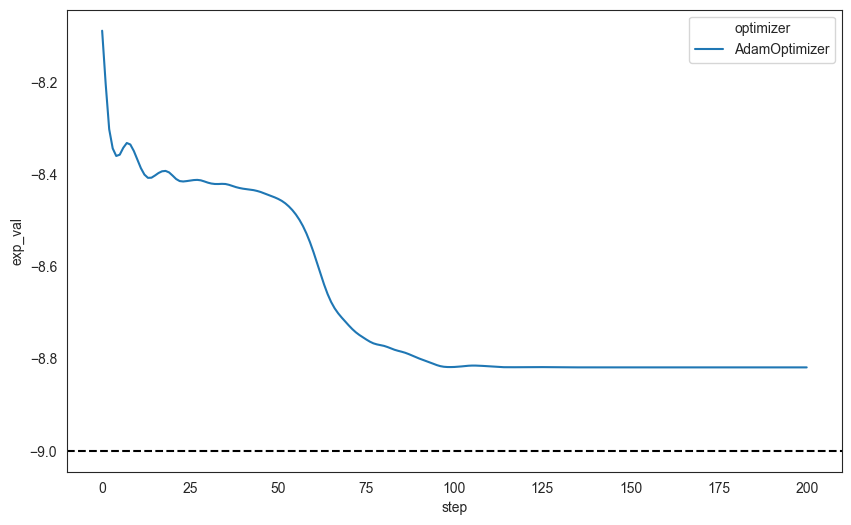

In [160]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style("white")

g = sns.lineplot(
    x="step",
    y="exp_val",
    hue="optimizer",
    data=df,
    ax=ax,
)

ax.axhline(y=min_energy, color="black", linestyle="--", label="Ground state")

## Conclusion

In this notebook, we have introduced the MaxCut problem and the QAOA algorithm. We have also shown how to use QAOA to solve the MaxCut problem. We have also introduced the XY-mixer QAOA, a variant of the QAOA algorithm that uses the XY-mixer Hamiltonian.
